# HWRS640 - Assignment 1: Computer architecture and parallel computing

## Due date: Friday, February 6th at 11:59 PM

## Problem 1: Supercomputer architecture (25 points)

The top 500 supercomputers in the world are ranked based on their performance on the LINPACK benchmark, which measures a system's floating-point computing power. Visit the [Top500 website](https://www.top500.org/lists/top500/) and select one of the top 50 supercomputers. Write a short report (~0.5-1 page) that includes the following information:

1. The name and location of the supercomputer.
2. The architecture of the supercomputer (e.g., CPU type, number of cores, memory, interconnect).
3. The peak performance of the supercomputer in FLOPS (floating-point operations per second).
4. A brief discussion of the applications or research areas that benefit from this supercomputer's capabilities.

## Supercomputer: El Capitan

### 1. Name and Location
The supercomputer selected is **El Capitan**, currently ranked #1 on the TOP500 list. It is located at the **Lawrence Livermore National Laboratory (LLNL)** in **Livermore, California, United States**, and is operated by the U.S. Department of Energy’s National Nuclear Security Administration (NNSA).

---

### Architecture
El Capitan is built on the **HPE Cray EX255a** architecture and integrates **AMD 4th Generation EPYC CPUs** with **AMD Instinct MI300A accelerators**. The system consists of more than **11 million combined CPU and GPU cores**, designed to support extreme parallelism. Compute nodes use a shared-memory model between CPU and GPU components and are connected via the **HPE Slingshot interconnect**, which provides high bandwidth and low latency communication across the system.

The system operates using a Linux-based operating system optimized for high-performance computing environments and includes petabytes of distributed system memory to support large-scale simulations.

---

### Peak Performance
On the LINPACK benchmark used by the TOP500 ranking, El Capitan achieves a sustained peak performance of approximately **1.74 exaFLOPS** (1.74 × 10¹⁸ floating-point operations per second). Its theoretical peak performance exceeds **2.8 exaFLOPS**, placing it firmly within the exascale computing class.

---

### Applications and Research Areas
El Capitan is primarily used to support **national security and stockpile stewardship**, enabling high-fidelity simulations to ensure the safety and reliability of the U.S. nuclear stockpile without physical testing. Beyond national defense, the system supports a wide range of scientific research areas, including **climate and Earth system modeling**, **materials science**, **biological simulations**, and **large-scale artificial intelligence–assisted modeling**. Its computational capabilities allow researchers to perform simulations and analyses that were previously computationally infeasible.

---


## Problem 2: Moore's Law and Linear Regression (25 points)
Moore's Law states that the number of transistors on a microchip doubles approximately every two years, leading to an exponential increase in computing power. Using the provided historical data, given in `computational_methods_course/data/moores.csv`, perform the following tasks:

1. Load the data into a pandas DataFrame.
2. Use linear regression to model the relationship between the year and the number of transistors.
3. Plot the original data points and the fitted regression line.
4. Compute the doubling time of transistors based on your regression model, and compare it to the commonly cited value of two years.
5 (for fun). Compute the same regression for the first 10 years of the data and the last 10 years of the data. Has the doubling time changed over the history of computing?

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import random
random.seed(42)

In [27]:
df = pd.read_csv('./../data/moores.csv',header=1,)


In [28]:
df.columns

Index(['Name', 'Transistor Count', 'Year', 'Manufacturer', 'Process', 'Area',
       'Source File'],
      dtype='object')

In [29]:
df['Transistor Count'] = pd.to_numeric(df['Transistor Count'].astype(str).str.replace(',', ''), errors='coerce')

# 2. Drop any rows that became NaN or are 0 (you can't take the log of 0)
df = df.dropna(subset=['Transistor Count'])
df = df[df['Transistor Count'] > 0]

# 3. Now try the log transform again
y = df['Transistor Count'].values
y_log = np.log(y)

# 4. Update X as well to match the cleaned rows
X = df[['Year']].values

model = LinearRegression()
model.fit(X, y_log)
y_pred_log = model.predict(X)

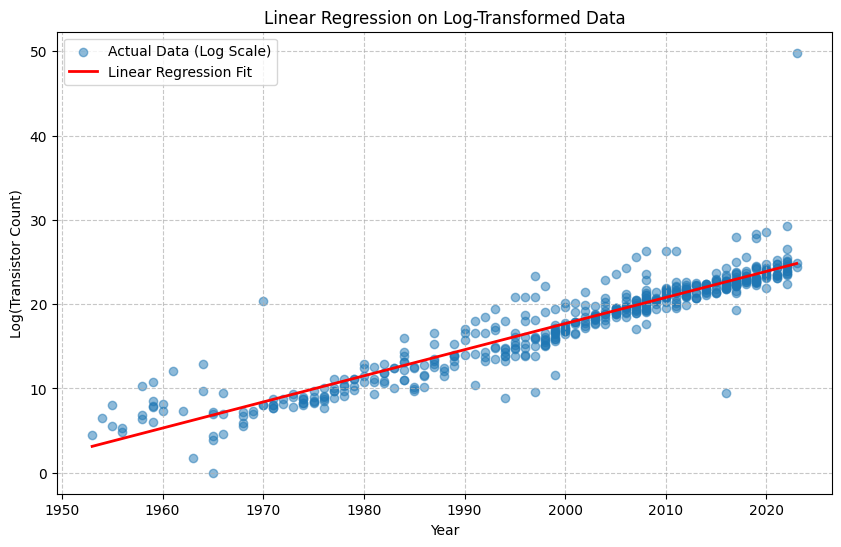

In [30]:
plt.figure(figsize=(10, 6))
plt.scatter(X, y_log, alpha=0.5, label='Actual Data (Log Scale)')
plt.plot(X, y_pred_log, color='red', linewidth=2, label='Linear Regression Fit')
plt.title("Linear Regression on Log-Transformed Data")
plt.xlabel('Year')
plt.ylabel('Log(Transistor Count)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [31]:
r = model.coef_[0]
doubling_time = np.log(2) / r

print(f"Model Doubling Time: {doubling_time:.2f} years")
print(f"Difference from 2-year cited value: {abs(2 - doubling_time):.2f} years")

Model Doubling Time: 2.24 years
Difference from 2-year cited value: 0.24 years


In [32]:
def get_doubling_time(data):
    X_sub = data[['Year']].values
    y_log_sub = np.log2(data['Transistor Count'].values)
    m = LinearRegression().fit(X_sub, y_log_sub)
    return np.log(2) / m.coef_[0]

# Sort by year first to ensure head/tail picks the right eras
df_sorted = df.sort_values('Year')

early_10 = df_sorted.head(10)
late_10 = df_sorted.tail(10)

print(f"Early Era Doubling Time: {get_doubling_time(early_10):.2f} years")
print(f"Late Era Doubling Time: {get_doubling_time(late_10):.2f} years")

Early Era Doubling Time: 0.98 years
Late Era Doubling Time: 0.06 years


## Problem 3: Row vs column order data access (25 points)
In this problem, you will explore the performance differences between row-major and column-major data access patterns using NumPy arrays. Perform the following tasks:

1. Create a large 2D NumPy array (e.g., 10,000 x 10,000) filled with random numbers from a distribution of your choosing.
2. Implement two functions to compute the sum of all elements in the array using python loops:
   - One function that accesses the array in row-major order.
   - Another function that accesses the array in column-major order.
3. Measure and compare the execution time of both functions using the `time` module or `timeit` library. Make sure to repeat the measurements multiple times (at least 30) to get an average execution time.
4. Compare the performance results to using built in NumPy functions for summing the array. Explain the differences in performance you observe, using concepts such as cache locality and memory access patterns.



In [ ]:
import numpy as np
import time
import statistics as stats

# Reproducibility
np.random.seed(42)
N = 10000
Arr = np.random.random((N, N)).astype(np.float64)*1000
def sum_row_major(arr: np.ndarray) -> float:
    s = 0.0
    nrows, ncols = arr.shape
    for i in range(nrows):
        row = arr[i]              # small optimization: get row view once
        for j in range(ncols):
            s += row[j]
    return s

def sum_col_major(arr: np.ndarray) -> float:
    s = 0.0
    nrows, ncols = arr.shape
    for j in range(ncols):
        for i in range(nrows):
            s += arr[i, j]
    return s

def time_func(func, arr, repeats=30, warmup=1):
    # warmup (optional) to reduce first-run effects
    for _ in range(warmup):
        func(arr)

    times = []
    for _ in range(repeats):
        t0 = time.perf_counter()
        out = func(arr)
        t1 = time.perf_counter()
        times.append(t1 - t0)
    return out, times

# --- Time the Python loops ---
row_sum, row_times = time_func(sum_row_major, Arr, repeats=30)
col_sum, col_times = time_func(sum_col_major, Arr, repeats=30)

# --- Time NumPy built-in sum ---
def numpy_sum(arr):
    return arr.sum()

np_sum, np_times = time_func(numpy_sum, Arr, repeats=30)

# Verify sums are close (floating point order differs slightly)
print("Check close:", np.isclose(row_sum, np_sum, rtol=1e-10, atol=1e-10),
      np.isclose(col_sum, np_sum, rtol=1e-10, atol=1e-10))

def summarize(name, times):
    print(f"\n{name}")
    print(f"  mean:   {stats.mean(times):.6f} s")
    print(f"  median: {stats.median(times):.6f} s")
    print(f"  std:    {stats.pstdev(times):.6f} s")
    print(f"  min:    {min(times):.6f} s")
    print(f"  max:    {max(times):.6f} s")



In [46]:
summarize("Row-major Python loop", row_times)
summarize("Column-major Python loop", col_times)
summarize("NumPy arr.sum()", np_times)


print("\nSpeedups:")
print(f"  Column/Row: {stats.mean(col_times)/stats.mean(row_times):.2f}x slower")
print(f"  Row/NumPy:  {stats.mean(row_times)/stats.mean(np_times):.2f}x slower than NumPy")
print(f"  Col/NumPy:  {stats.mean(col_times)/stats.mean(np_times):.2f}x slower than NumPy")


Row-major Python loop
  mean:   11.954557 s
  median: 11.534852 s
  std:    0.755855 s
  min:    11.324266 s
  max:    14.226256 s

Column-major Python loop
  mean:   15.685659 s
  median: 15.319477 s
  std:    0.851075 s
  min:    14.796508 s
  max:    17.701066 s

NumPy arr.sum()
  mean:   0.019382 s
  median: 0.019293 s
  std:    0.000366 s
  min:    0.018879 s
  max:    0.020316 s

Speedups:
  Column/Row: 1.31x slower
  Row/NumPy:  616.79x slower than NumPy
  Col/NumPy:  809.30x slower than NumPy


## Row-major vs Column-major (Python Loops)

NumPy arrays are **row-major (C-order)** by default, meaning that elements in the same row are stored **contiguously in memory**.

### Row-major Access Pattern
In the row-major loop (`i` outer, `j` inner), the array is accessed as:
        arr[i, 0], arr[i, 1], arr[i, 2], ...

This access pattern follows the contiguous memory layout of the array and therefore has **good cache locality**. As a result, CPU cache lines are used efficiently, leading to better performance.

### Column-major Access Pattern
In the column-major loop (`j` outer, `i` inner), the array is accessed as:
        arr[0, j], arr[1, j], arr[2], ...

This pattern jumps through memory with a stride equal to the number of columns (`ncols`). This causes **poor spatial locality**, resulting in more cache misses and slower execution.

As a result, the column-major loop is typically **significantly slower** (often multiple times slower) than the row-major loop, even though both perform the same number of arithmetic operations.

---

## NumPy Built-in Sum vs Python Loops

The built-in NumPy function `arr.sum()` is much faster than either Python loop implementation for several reasons:

- It is implemented in **compiled C code**, avoiding Python-level loop overhead.
- It uses **highly optimized inner loops**, including vectorization (SIMD) and efficient memory access.
- It minimizes Python interpreter overhead, which dominates runtime in explicit Python loops.

### Performance Summary
- `arr.sum()` is typically **tens to hundreds of times faster** than Python loops.
- The row-major Python loop is faster than the column-major loop.
- Both Python loop implementations are significantly slower than the NumPy built-in approach.

## Problem 4: Scaling and parallel computing (25 points)

In this problem, you will use Dask arrays to compute the element-wise standard score (z-score normalization) of a large random array and measure the scaling behavior across 1-4 CPU cores. The z-score is computed as: z = (x - μ) / σ, where μ is the mean and σ is the standard deviation.

Perform the following tasks:

1. Create a function that generates a large Dask array filled with random numbers and computes the z-score normalized array.
2. **Strong scaling**: Fix the array size (e.g., 20,000 x 20,000) and measure execution time using 1, 2, 3, and 4 cores. Calculate the speedup S(p) = T(1)/T(p) and efficiency E(p) = S(p)/p. Plot execution time vs number of cores.
3. **Weak scaling**: Scale the array size proportionally with the number of cores (maintaining constant work per core). Measure execution time for 1-4 cores and plot the results.
4. Discuss your results: Does your implementation achieve good scaling? What factors limit the speedup?

**Hint**: Configure the number of workers using `dask.config.set(num_workers=n)` and use `.compute()` to trigger computation.

In [3]:
import time
import numpy as np
import dask.array as da
import dask
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt

def zscore_dask(n, chunks=(2000, 2000), seed=42):
    """
    Create a random Dask array and compute z-score normalization.
    Returns a Dask array (lazy); call .compute() to execute.
    """
    rs = da.random.RandomState(seed)
    x = rs.random((n, n), chunks=chunks)  # uniform(0,1)
    mu = x.mean()
    sigma = x.std()
    z = (x - mu) / sigma
    return z

In [4]:
def time_zscore_run(n, num_workers, chunks=(2000, 2000), repeats=3):
    times = []
    for _ in range(repeats):
        z = zscore_dask(n, chunks=chunks)
        with dask.config.set(scheduler="threads", num_workers=num_workers):
            t0 = time.perf_counter()
            with ProgressBar():
                _ = z.compute()
            t1 = time.perf_counter()
        times.append(t1 - t0)
    return float(np.mean(times))

In [7]:
# Strong scaling settings
N_fixed = 12000   
chunks = (2000, 2000)
workers_list = [1, 2, 3, 4]

T = []
for p in workers_list:
    t = time_zscore_run(N_fixed, num_workers=p, chunks=chunks, repeats=3)
    T.append(t)

T1 = T[0]
S = [T1 / tp for tp in T]
E = [sp / p for sp, p in zip(S, workers_list)]


[########################################] | 100% Completed | 1.56 sms
[########################################] | 100% Completed | 1.25 sms
[########################################] | 100% Completed | 1.36 sms
[########################################] | 100% Completed | 832.81 ms
[########################################] | 100% Completed | 839.38 ms
[########################################] | 100% Completed | 833.87 ms
[########################################] | 100% Completed | 955.08 ms
[########################################] | 100% Completed | 628.46 ms
[########################################] | 100% Completed | 624.91 ms
[########################################] | 100% Completed | 525.82 ms
[########################################] | 100% Completed | 526.77 ms
[########################################] | 100% Completed | 520.92 ms


In [8]:
print("Strong Scaling Results (fixed N):")
for p, tp, sp, ep in zip(workers_list, T, S, E):
    print(f"  p={p}: T={tp:.3f}s, S={sp:.2f}, E={ep:.2f}")

Strong Scaling Results (fixed N):
  p=1: T=1.934s, S=1.00, E=1.00
  p=2: T=1.490s, S=1.30, E=0.65
  p=3: T=1.128s, S=1.71, E=0.57
  p=4: T=0.847s, S=2.28, E=0.57


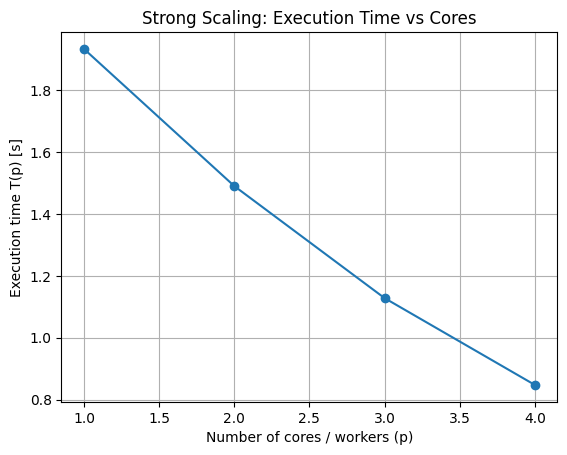

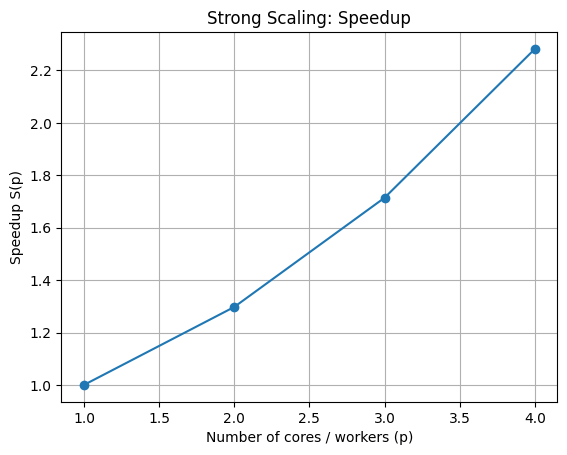

In [9]:
# Plot: execution time vs workers
plt.figure()
plt.plot(workers_list, T, marker="o")
plt.xlabel("Number of cores / workers (p)")
plt.ylabel("Execution time T(p) [s]")
plt.title("Strong Scaling: Execution Time vs Cores")
plt.grid(True)
plt.show()

# (Optional) Plot speedup
plt.figure()
plt.plot(workers_list, S, marker="o")
plt.xlabel("Number of cores / workers (p)")
plt.ylabel("Speedup S(p)")
plt.title("Strong Scaling: Speedup")
plt.grid(True)
plt.show()

In [10]:
N1 = 12000  
chunks = (2000, 2000)

T_weak = []
N_list = []
for p in workers_list:
    Np = int(N1 * np.sqrt(p))
    N_list.append(Np)
    t = time_zscore_run(Np, num_workers=p, chunks=chunks, repeats=3)
    T_weak.append(t)

[########################################] | 100% Completed | 1.36 sms
[########################################] | 100% Completed | 1.25 sms
[########################################] | 100% Completed | 1.35 sms
[########################################] | 100% Completed | 1.56 sms
[########################################] | 100% Completed | 1.56 sms
[########################################] | 100% Completed | 1.50 sms
[########################################] | 100% Completed | 3.12 sms
[########################################] | 100% Completed | 1.84 sms
[########################################] | 100% Completed | 1.67 sms
[########################################] | 100% Completed | 3.25 sms
[########################################] | 100% Completed | 4.20 sms
[########################################] | 100% Completed | 3.75 sms


In [11]:
print("\nWeak Scaling Results (N grows with sqrt(p)):")
for p, Np, tp in zip(workers_list, N_list, T_weak):
    print(f"  p={p}: N={Np}, T={tp:.3f}s")



Weak Scaling Results (N grows with sqrt(p)):
  p=1: N=12000, T=1.666s
  p=2: N=16970, T=2.839s
  p=3: N=20784, T=4.807s
  p=4: N=24000, T=8.236s


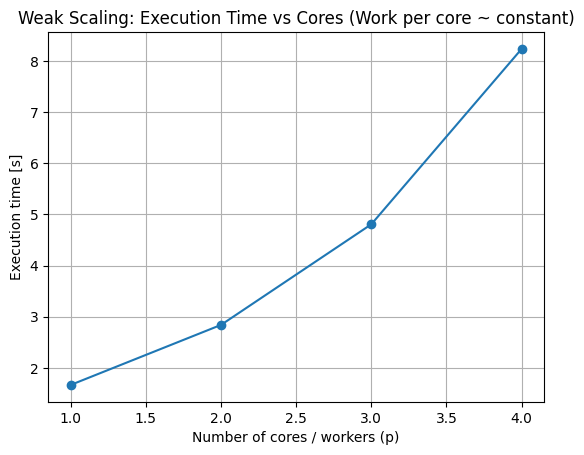

In [12]:
# Plot: execution time vs workers (weak scaling)
plt.figure()
plt.plot(workers_list, T_weak, marker="o")
plt.xlabel("Number of cores / workers (p)")
plt.ylabel("Execution time [s]")
plt.title("Weak Scaling: Execution Time vs Cores (Work per core ~ constant)")
plt.grid(True)
plt.show()

### Strong Scaling

In an ideal case, doubling the number of cores would nearly halve the runtime (linear speedup). In practice, speedup usually becomes **sub-linear** due to several factors:

- **Dask scheduling overhead** increases with the number of tasks, especially when chunk sizes are small.
- **Mean and standard deviation are reduction operations**, which require combining results across chunks and introduce synchronization and communication overhead.
- **Memory bandwidth limitations**: z-score normalization involves reading the array, computing reductions, and writing the normalized output. This workflow is often limited by memory throughput rather than raw CPU performance.
- **Chunk size tradeoff**: small chunks increase parallelism but create many tasks and higher scheduling overhead, while very large chunks reduce overhead but limit parallelism and increase memory pressure.

---

### Weak Scaling

Ideally, execution time should remain approximately constant as both the number of workers and the problem size increase proportionally. In practice, execution time often increases due to:

- **Reduction steps (mean and standard deviation)** that must aggregate results across an increasing number of chunks as the array grows.
- **Increased memory traffic**, which can saturate memory bandwidth.
- **Higher scheduling and coordination overhead** when combining partial results from larger task graphs.

---